In [1]:
import os
import pathlib
import nltk
import numpy as np
from unicodedata import normalize
import collections
%reload_ext autoreload
%autoreload 2

import pickle, os
from pathlib import Path
import datetime

from model import *
from simplifier import *
from spellchecker import *

nltk.download('words')
nltk.download('punkt')


[nltk_data] Downloading package words to /home/filipp/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /home/filipp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
path_data = 'data-simplification/wikilarge/wiki.full.aner.'

In [3]:
train_src = open(path_data+'train.src', "r").readlines()
train_dst = open(path_data+'train.dst', "r").readlines()
train_ori_src = open(path_data+'ori.train.src', "r").readlines()
train_ori_dst = open(path_data+'ori.train.dst', "r").readlines()

valid_src = open(path_data+'valid.src', "r").readlines()
valid_dst = open(path_data+'valid.dst', "r").readlines()
valid_ori_src = open(path_data+'ori.valid.src', "r").readlines()
valid_ori_dst = open(path_data+'ori.valid.dst', "r").readlines()

### Comparison of datasets; will work with original first. Named entity identification is applied to get the modified dataset. Might facilitate trainining working with this.

In [4]:
print(train_src[114], 
      train_ori_src[114], 
      train_ori_dst[114],
      train_dst[114],
      valid_ori_src[11],
      valid_ori_dst[11],
      sep="\n")

ORGANIZATION@1 crews conducted backburning operations to ensure containment of the fire on NUMBER@1 February , warning residents of areas between LOCATION@1 and Warragul about smoke from those fires .

DSE crews conducted backburning operations to ensure containment of the fire on 9 February , warning residents of areas between Pakenham and Warragul about smoke from those fires .

People between Pakenham and Warragul were warned about smoke from those fires .

People between LOCATION@1 and Warragul were warned about smoke from those fires .

The Summer of Love became a defining moment of the 1960s , as the hippie counterculture movement came into public awareness .

Thousands of young people from all over the world went to San Francisco to help create a hippie counterculture . The Summer of Love made the rest of America much more aware of the hippie movement .



### Restricting to a maximal sentence length

In [5]:
sent_len = 20
train_ori_src, train_ori_dst = shorten(train_ori_src, train_ori_dst, sent_len, short_dst=True)

In [6]:
#checking that the number of source and target samples match
len(train_ori_src), len(train_ori_dst)

(196222, 196222)

In [7]:
#one more example
print(train_ori_src[11],
      train_ori_dst[11],
      sep="\n")


Country Music Television , or CMT , is an American country music-oriented cable television network .

CMT -LRB- Country Music Television -RRB- is an American country music cable television channel .



### Use GloVe representation

In [8]:
representation_dimension = 300 #50,100, 200 or 300 
embedding_index = {}
file = os.path.join(str(pathlib.Path.home())+"/GloVe","glove.6B.{}d.txt".format(representation_dimension))
f= open(file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs



### A glimpse at the representations.

In [9]:
i = 0
for key, value in embedding_index.items():
    if i>5:
        break
    print(key, value)
    print(value.shape)
    i += 1

the [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-01 -3.9338e-01 -6.7945e-0

### Cleaning the source corpus
#### use the clean function from simplifier.py

In [10]:
clean_txt = clean(train_ori_src)

In [11]:
print("""
Example of clean_txt

Original: {}

Cleaned: {}
    """.format(train_ori_src[0:2], clean_txt[0:400]))


Example of clean_txt

Original: ["In a remarkable comparative analysis , Mandaean scholar Säve-Söderberg demonstrated that Mani 's Psalms of Thomas were closely related to Mandaean texts .\n", 'When Japan earned another race on the F1 schedule ten years later , it went to Suzuka instead .\n']

Cleaned: in a remarkable comparative analysis mandaean scholar savesoderberg demonstrated that mani s psalms of thomas were closely related to mandaean textswhen japan earned another race on the schedule ten years later it went to suzuka insteadthis marked the first motorcycle racing event at the facility since its first month of operation in august 1909a scythe lrb oxford english dictionary oxford univers
    


### Tokenize the clean_txt
#### using nltk.word_tokenize

In [12]:
#token_list_src = nltk.word_tokenize(clean_txt)
token_list_src = tokenize(clean_txt) #the tokenize function is simply nltk.word_tokenize, but could/should be improved
print(token_list_src[0:30],"\n")
print("Total tokens : ", len(token_list_src))

['in', 'a', 'remarkable', 'comparative', 'analysis', 'mandaean', 'scholar', 'savesoderberg', 'demonstrated', 'that', 'mani', 's', 'psalms', 'of', 'thomas', 'were', 'closely', 'related', 'to', 'mandaean', 'textswhen', 'japan', 'earned', 'another', 'race', 'on', 'the', 'schedule', 'ten', 'years'] 

Total tokens :  3590723


In [13]:
# comparison with source tokens when entities replaced by placeholders
token_list_with_ent_src = nltk.word_tokenize(clean(train_src))
print(token_list_with_ent_src[0:20],"\n")
print("Total tokens : ", len(token_list_with_ent_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'a', 'and', 'that', 'her'] 

Total tokens :  5244402


In [14]:
#total vocabulary size in source
print("""
Total vocabulary size in original sourse {}
Total vocabulary size in entitity tagged sourse: {}
""".format(len(set(token_list_src)), len(set(token_list_with_ent_src))))



Total vocabulary size in original sourse 257164
Total vocabulary size in entitity tagged sourse: 256472



### Looking at the frequencies

In [15]:
# #building vocabulary using the build_vocabulary function from simplifier, drops tokens with frequency < threshold 
token_list_src_over_threshold = build_vocabulary(token_list_src, threshold=5) 
vocabulary_size_source = len(token_list_src_over_threshold) + 1 # +1 for the <UNK> token
print("""
The source vocabulary size is {}
The 10 most common words/tokens with their frequencies are 
""".format(vocabulary_size_source))
for x in token_list_src_over_threshold[:10]:
    print("{}: {}".format(x[0], x[1]))


The source vocabulary size is 34885
The 10 most common words/tokens with their frequencies are 

the: 229774
of: 136815
in: 112224
and: 100417
a: 93072
is: 79595
to: 55279
lrb: 50868
rrb: 40321
was: 35531


### Which words/tokens from corpus are missing in GloVe; obviously lots of misspelled/not properly separated words.

In [16]:
not_in_GloVe = []
for word, _ in token_list_src_over_threshold:
    if word not in embedding_index:
        not_in_GloVe.append(word)
len(not_in_GloVe)

4247

### Using spell checker (a la Norvig)
#### To reduce the number of words in token_list_src_over_threshold which are not in GloVe one should use a spellchecker in the tokenization process

In [17]:
#the function separate_words from spellchecker.py only deals with word splitting errors, but these already amount to a large part
separate_words("umbrellaas", embedding_index)

['umbrella', 'as']

##### Separating a word not in the embedding might give two words in the embedding. Run a couple of times, to see that the number of words not in GloVe decreases

In [18]:
for word in not_in_GloVe:
    if len(separate_words(word, embedding_index))>1:
        not_in_GloVe.remove(word)
        
len(not_in_GloVe)

2201

In [19]:
print("""
Examples of words in the training corpus not in the GloVe embedding index:
(there are still lots of non-splitted words)
""")
for x in not_in_GloVe[:20]:
      print(x)


Examples of words in the training corpus not in the GloVe embedding index:
(there are still lots of non-splitted words)

francethe
rrbin
statesthe
paysdelaloire
francein
pasdecalais
nordpasdecalais
singersongwriter
playerthe
englandthe
alpesmaritimes
presentday
atlantiques
bestknown
seasonthe
timethe
awardwinning
payperview
areathe
citythe


In [20]:
# the improve_toke_list function from spellchecker.py applies separates tokens which are not in the embedding index and adds the result 
# To the token list. In the first step, the frequencies are removed.
improved_token_list = improve_token_list([x[0] for x in token_list_src_over_threshold], \
                                         embedding_index, separate_words)
improved_token_list = improve_token_list([x for x in improved_token_list], \
                                         embedding_index, separate_words)

In [21]:
# remove duplicates
improved_token_list = list((set(improved_token_list)))
len(improved_token_list)

32310

### Creating token-index-dictionary

In [22]:
# the function build_word2index creates a word-index dictionary, indices start with 1
tokenizer_src = build_word2index(improved_token_list)
print('tokenizer_src has {} words'.format(len(tokenizer_src)))

tokenizer_src has 32311 words


In [23]:
today_string = str(datetime.date.today().day) + str(datetime.date.today().month) + str(datetime.date.today().year) 
models_path = 'models/'+today_string # choose a name
Path(models_path).mkdir(parents=True, exist_ok=True)
tokenizer_file = os.path.join(models_path, 'tokenizer_src.pkl') #always save the word-index dictionary !
with open(tokenizer_file, 'wb') as file:
    pickle.dump(tokenizer_src, file, protocol=pickle.HIGHEST_PROTOCOL)

# #to load
# with open(tokenizer_file, 'rb') as file:
#     to = pickle.load(file)



### embedding matrix to use the GloVe embedding in the model later

In [24]:
embedding_size = representation_dimension # GloVe 
vocabulary_size_source = len(tokenizer_src)+1
embedding_matrix = np.zeros((vocabulary_size_source, embedding_size))
for word, idx in tokenizer_src.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [25]:
embedding_matrix.shape

(32312, 300)

### Let's look at sentence lengths

In [26]:
lengths=[]
lengths = [len((tokenizer(x))) for x in train_ori_src]

In [27]:
print("min", np.min(lengths))
print("mean", np.mean(lengths))
print("max", np.max(lengths))
print("std", np.std(lengths))

min 0
mean 19.73733322461294
max 104
std 10.930596635047197


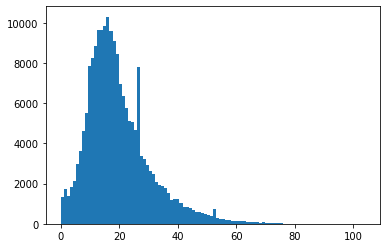

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()
plt.close()

In [29]:
#looking at the extreme (wrt length) source sentences
arg = np.argmax(lengths)
lengths.pop(arg) #dropping the longest sentence
np.max(lengths)
mx = np.argmax(lengths)
mn = np.argmin(lengths)
print('The longest sentence has {} tokens.'.format(np.max(lengths)))
print(train_ori_src[mx], 
      train_ori_src[mn],
     sep="\n")


The longest sentence has 104 tokens.
John Simm -LRB- born 10 July 1970 -RRB- is an English stage and screen actor .

! ''



In [30]:
# The still need to set a maximum length for the source sentences (the target sentences were filtered to be 
# < sent_len), longer senteces will be truncated
sentence_length = 60
sentence_length

60

In [31]:
# creating source training and validation arrays
# using the encode and tokenizer functions from simplifier.py

train_x = np.array([encode(tokenizer(line, add_toc=True), \
                            tokenizer_src, sentence_length, pad=True) for line in \
                    train_ori_src]).reshape(-1, sentence_length)

valid_x = np.array([encode(tokenizer(line, add_toc=True), \
                            tokenizer_src, sentence_length, pad=True) for line in \
                    valid_ori_src]).reshape(-1, sentence_length)

In [32]:
print(train_x.shape,
      valid_x.shape)

(196222, 60) (992, 60)


In [33]:
# testing the get_word function from simplifier.py
get_word(3762, tokenizer_src)

'eua'

In [34]:
# Let's have a look at an example sentence, its tokenization and encoding
indx = 12 # choose one
print("""
The original sentence is:
{}
The tokenization list is:
{}

The encoded array is:
{}""".format(train_ori_src[indx:indx+1][0], \
             [tokenizer(line, add_toc=True) for line in train_ori_src[indx:indx+1]][0], \
                                  train_x[indx:indx+1][0])
     )



The original sentence is:
Sea surface temperature -LRB- SST -RRB- is the water temperature close to the surface .

The tokenization list is:
['<START>', 'sea', 'surface', 'temperature', 'lrb', 'sst', 'rrb', 'is', 'the', 'water', 'temperature', 'close', 'to', 'the', 'surface', '<END>']

The encoded array is:
[32311  2597 11419 31625 17471 32311 22424  8343 10776 19109 31625 13753
 22774 10776 11419 32311     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


In [35]:
lengths_dst = [len((tokenizer(x))) for x in train_ori_dst]

In [36]:
print("min", np.min(lengths_dst))
print("mean", np.mean(lengths_dst))
print("max", np.max(lengths_dst)) # since we set the max to be < sent_len, this should be sent_len - 1
print("std", np.std(lengths_dst))

min 0
mean 10.73831170816728
max 19
std 5.300009417464431


In [37]:
mx = np.argmax(lengths_dst)
train_ori_dst[mx]
len(train_ori_dst)

196222

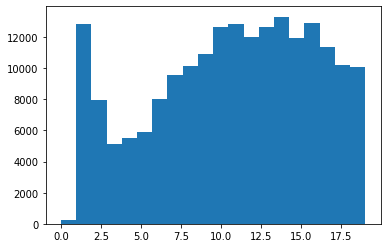

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths_dst, bins=20)
plt.show()
plt.close()

In [39]:
sentence_length_dst = max(lengths_dst)
assert sentence_length_dst == sent_len - 1 

### Look at output vocabulary

In [40]:
token_list_dst_over_threshold = build_vocabulary(tokenize(clean(train_ori_dst)), threshold=3)
vocabulary_size_dst = len(token_list_dst_over_threshold) + 1 # +1 for the <UNK> token
print("""
The target vocabulary size is {}
The 10 most common words/tokens with their frequencies are 
""".format(vocabulary_size_dst))
for x in token_list_dst_over_threshold[:10]:
    print("{}: {}".format(x[0], x[1]))


The target vocabulary size is 33506
The 10 most common words/tokens with their frequencies are 

the: 113303
of: 70561
in: 64149
is: 62299
a: 53804
and: 39597
was: 24379
to: 23535
lrb: 22501
rrb: 14729


In [41]:
#creating and improving the target token list, as before, it makes sense to run this step more than once
improved_token_list_dst = improve_token_list([x[0] for x in token_list_dst_over_threshold], \
                                         embedding_index, separate_words)
improved_token_list_dst = list((set(improved_token_list_dst)))
vocabulary_size_dst = len(improved_token_list_dst) + 1

improved_token_list_dst = improve_token_list([x for x in improved_token_list_dst], \
                                         embedding_index, separate_words)
vocabulary_size_dst = len(set(improved_token_list_dst)) + 1
print('The destination vocabulary size is {}'.format(vocabulary_size_dst))

The destination vocabulary size is 28936


In [42]:
#Which words are not in the GloVe represantation
not_in_GloVe = []
for word in improved_token_list_dst:
    if word not in embedding_index:
        not_in_GloVe.append(word)

print("""
Examples of words in the training (destination) corpus not in the GloVe embedding index:
(there are still lots of non-splitted words)
{} words in total
""".format(len(not_in_GloVe)))
for x in not_in_GloVe[:10]:
      print(x)


Examples of words in the training (destination) corpus not in the GloVe embedding index:
(there are still lots of non-splitted words)
308 words in total

usitatissimum
designskolen
interamnia
eupatridae
majorthe
arshawsky
pclinuxos
francereferencesit
poznurr
sabellianism


In [43]:
# building the word index dictionary for the target corpus, adding <START> and <END> tokens
tokenizer_dst = build_word2index(improved_token_list_dst, add_toc=True)
vocabulary_size_dst = len(tokenizer_dst)+1 # for the <UNK> token
print('The destination vocabulary has {} tokens'.format(vocabulary_size_dst))

The destination vocabulary has 28939 tokens


In [44]:
Path(models_path).mkdir(parents=True, exist_ok=True)
tokenizer_file = os.path.join(models_path, 'tokenizer_dst.pkl')
with open(tokenizer_file, 'wb') as file:
    pickle.dump(tokenizer_dst, file, protocol=pickle.HIGHEST_PROTOCOL)
print('The destination word-index dictionary saved under {}'.format(tokenizer_file))
# #to load
# with open('tokenizer_dst.pkl', 'rb') as file:
#     tokenizer_dst = pickle.load(file)



The destination word-index dictionary saved under models/262020/tokenizer_dst.pkl


In [45]:
# creating target training and validation arrays
# using the encode and tokenizer functions from simplifier.py
train_y = np.array([encode(tokenizer(line, add_toc=True), \
                            tokenizer_dst, sentence_length_dst, pad=True) for line in \
                    train_ori_dst]).reshape(-1, sentence_length_dst)

valid_y = np.array([encode(tokenizer(line, add_toc=True), \
                            tokenizer_dst, sentence_length_dst, pad=True) for line in \
                    valid_ori_dst]).reshape(-1, sentence_length_dst)

In [46]:
print(train_y.shape, valid_y.shape, sep="\n")

(196222, 19)
(992, 19)


In [47]:
#example of the tokenizing with the tokenizer function
line = train_ori_dst[0]
print(line)
tokenizer(line, add_toc=True)

Mandaean scholar Säve-Söderberg showed that Mani 's Psalms of Thomas were closely related to Mandaean texts .



['<START>',
 'mandaean',
 'scholar',
 'save',
 'soderberg',
 'showed',
 'that',
 'mani',
 's',
 'psalms',
 'of',
 'thomas',
 'were',
 'closely',
 'related',
 'to',
 'mandaean',
 'texts',
 '<END>']

In [48]:
train_y[0:3]

array([[28937, 15854, 14260, 10484, 28936, 10731, 17244, 21220,  5401,
        28936,  8230, 17476,  5703,  1137,   350, 20459, 15854, 17809,
        28938],
       [28937,  9349,  9373,  1969,  9161, 20831, 20459,  9670, 28936,
         9851, 13784,   899,  3755,  9500,  4667, 20459, 17257,  4191,
        28938],
       [28937,  7025,  1969,  9670,  3818, 14729, 16441, 18183, 28599,
         9670, 21842, 15594, 18391,  3818, 21678,  8230,   148, 21107,
         4198]], dtype=int32)

#### Embedding matrix for the decoder

In [49]:
embedding_size = representation_dimension # GloVe 
vocabulary_size_dst = len(tokenizer_dst)+1 # <UNK> token
embedding_dec_matrix = np.zeros((vocabulary_size_dst, embedding_size))
for word, idx in tokenizer_dst.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_dec_matrix[idx] = embedding_vector
embedding_dec_matrix.shape

(28939, 300)

In [50]:
## Neptune monitoring
# from tensorflow.keras.callbacks import Callback
# class NeptuneMonitor(Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         my_metric = logs['loss']
#         neptune.send_metric('Sparse Categorical Cross Entropy', epoch, my_metric)

In [100]:
#building the training model and the encoder, decoder models for predicter; using the corr. function from model.py
model, encoder_model, decoder_model = build_ed_dp_model(
    vocabulary_size_source,
    vocabulary_size_dst, 
    sentence_length, 
    sentence_length_dst, 
    300, 
    300, 
    use_emb=embedding_matrix, 
    unfreeze_emb=True, 
    use_dec_emb=embedding_dec_matrix, 
    unfreeze_dec_emb=False
)

In [101]:
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 300)    9693600     input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, None, 300)    721200      embedding_4[0][0]                
____________________________________________________________________________________________

In [102]:
from tensorflow.keras.utils import plot_model
model_name = 'model_ed_dp_rms_3Gemb_unfrENC_24_bs4_50ep' #give it a name
plot_model(model, 
           show_shapes=True, 
           to_file=os.path.join(models_path, '{}.png'.format(model_name)))

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [103]:
# optimizers and model compilation
rms = optimizers.RMSprop(lr=0.0005)
nadm =optimizers.Nadam(learning_rate=0.0005, beta_1=0.99, beta_2=0.99999)
admx = optimizers.Adamax(learning_rate=0.0006, beta_1=0.999, beta_2=0.999999)
model.compile(
    optimizer=rms,
    #optimizer="adam",
    #optimizer=admx,
    #loss="categorical_crossentropy",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [104]:
import gc
gc.collect()

47023

In [105]:
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger(os.path.join(models_path,"history_log_"+model_name+".csv"), append=True)

In [106]:
#Training
batch_size = 4
n_samples = 24 #train_x.shape[0]
history = model.fit_generator(
    generator_ed(train_x, train_y, batch_size, vocabulary_size_source, vocabulary_size_dst, \
                 samples=n_samples, shf=False, onehot_dst=True, onehot_src=False),
    epochs=40,
    #batch_size=50,
    #validation_split=0.2,
    #steps_per_epoch = train_x.shape[0]/batch_size,
    steps_per_epoch=n_samples/batch_size,
    validation_data=generator_ed(valid_x, valid_y, batch_size, vocabulary_size_source, \
         vocabulary_size_dst, samples=n_samples, shf=True, onehot_dst=True, onehot_src=False),
    validation_steps=batch_size,
  #  callbacks=[neptune_monitor]
    callbacks=[csv_logger]

)

Epoch 1/40
6/6 [==============================] - 6s 1s/step - loss: 6.9063 - accuracy: 0.3180 - val_loss: 6.2259 - val_accuracy: 0.3191
Epoch 2/40
6/6 [==============================] - 3s 433ms/step - loss: 4.9880 - accuracy: 0.3399 - val_loss: 6.0839 - val_accuracy: 0.2500
Epoch 3/40
6/6 [==============================] - 3s 431ms/step - loss: 3.9519 - accuracy: 0.3399 - val_loss: 5.8177 - val_accuracy: 0.2697
Epoch 4/40
6/6 [==============================] - 3s 443ms/step - loss: 3.5857 - accuracy: 0.3399 - val_loss: 6.0739 - val_accuracy: 0.2533
Epoch 5/40
6/6 [==============================] - 3s 426ms/step - loss: 3.4232 - accuracy: 0.3399 - val_loss: 5.6728 - val_accuracy: 0.3257
Epoch 6/40
6/6 [==============================] - 3s 443ms/step - loss: 3.3279 - accuracy: 0.3399 - val_loss: 4.8539 - val_accuracy: 0.4112
Epoch 7/40
6/6 [==============================] - 3s 432ms/step - loss: 3.2678 - accuracy: 0.3399 - val_loss: 5.6468 - val_accuracy: 0.3191
Epoch 8/40
6/6 [=======

In [107]:

Path(models_path).mkdir(parents=True, exist_ok=True)
model_file_path = os.path.join(models_path, model_name+'.h5')
encoder_file_path = os.path.join(models_path, model_name+'_encoder.h5')
decoder_file_path = os.path.join(models_path, model_name+'_decoder.h5')
model_hist_path = os.path.join(models_path, 'trainHistory_'+model_name)

with open(model_hist_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

model.save(model_file_path)
encoder_model.save(encoder_file_path)
decoder_model.save(decoder_file_path)

print('Model(s) and history saved under {} and {} respectively'.format(model_file_path, \
                                                                    model_hist_path))


#from tensorflow.keras.models import load_model
#model = load_model('model_ed_3200_150ep.h5')

Model(s) and history saved under models/262020/model_ed_dp_rms_3Gemb_unfrENC_24_bs4_50ep.h5 and models/262020/trainHistory_model_ed_dp_rms_3Gemb_unfrENC_24_bs4_50ep respectively


## from here onwards, it's a mess, still in progress

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

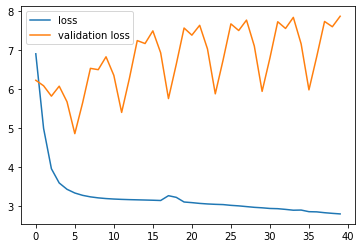

In [108]:
%matplotlib inline
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()
plt.close()

In [71]:
np.argmax(model.predict([train_x[0:1], train_y[0:1,1:]]), axis=2)[0]

array([ 1969, 15677,  9640, 20614, 21445, 20459,  9670,  9670, 17476,
        5703,  1137,   350, 20459, 15854, 17809, 28938,     0,     0])

In [72]:
print([get_word(x, tokenizer_dst) for x in np.argmax(model.predict([train_x[3:4], train_y[3:4,:-1]]), axis=2)[0]])

['was', 'lrb', 'not', 'old', 'english', 'english', 'english', 'dictionary', '1933', 'rrb', '<END>', None, None, None, None, None, None, None]


In [73]:
train_ori_dst[3:4]

['A scythe -LRB- , from Old English siðeOxford English Dictionary 1933 . -RRB-\n']

In [98]:
vocab_in = vocabulary_size_source
vocab_out = vocabulary_size_dst
length_in = sentence_length
lenght_out = sentence_length_dst
n_units = 300
n2_units = 300

encoder_input = Input(shape=(None,))# vocab_in+1))
encoder_emb_layer = layers.Embedding(vocab_in,
                                n_units,
                                #input_length=length_in,
                                #embeddings_initializer='lecun_uniform',
                                mask_zero=True,
                                #trainable=True
                                )
encoder_emb = encoder_emb_layer(encoder_input)
encoder_lstm = layers.LSTM(n_units, return_sequences=True, return_state=False)
encoder_lstm2 = layers.LSTM(n2_units, return_state=True)
#encoder_output = layers.RepeatVector(length_out)(encoder_output)
encoder_output, state_h, state_c = encoder_lstm2(encoder_lstm(encoder_emb))
encoder_states = [state_h, state_c]
#Decoder
decoder_input = Input(shape=(None,))# vocab_out+1))
decoder_emb_layer = layers.Embedding(vocab_out , n_units, mask_zero=True)
decoder_emb = decoder_emb_layer(decoder_input)
decoder_lstm2 = layers.LSTM(n2_units, return_sequences=True, return_state=False)
decoder_lstm = layers.LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_lstm2(decoder_emb, initial_state=encoder_states))
#decoder_output = layers.TimeDistributed(layers.Dense(vocab_out+1, activation='softmax'))(decoder_output)

decoder_dense = layers.Dense(vocab_out, activation='softmax')
decoder_output = decoder_dense(decoder_outputs)
decoder_state_input_h = Input(shape=(300,))
decoder_state_input_c = Input(shape=(300,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_emb2 = decoder_emb_layer(decoder_input)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_lstm2(decoder_emb2, initial_state=decoder_states_inputs))
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = models.Model(
            [decoder_input] + decoder_states_inputs,
            [decoder_outputs2] + decoder_states2)

In [81]:
import pydot
plot_model(decoder_model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [77]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    8681700     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
____________________________________________________________________________________________

In [113]:
import pdb
indx = 19
sequence = train_x[indx:indx+1]
token_dict = tokenizer_dst
token_dict_reverse = dict((index, word) for word, index in token_dict.items())
token_dict_reverse[0] = '<pad>'
length_out = 50     
enc = encoder_model
dec = decoder_model
states_value = enc.predict(sequence)

# Generate empty target sequence of length 1.
decoded_sequence = np.zeros((1,1))

# Populate the first character of target sequence with the start character.
decoded_sequence[0, 0] = token_dict['<START>']

# Sampling loop for a batch of sequences
# (to simplify, here we assume a batch of size 1).
stop_condition = False
decoded_sentence = ''

output_len = 0

while not stop_condition:
   
    
    #print(decoded_sequence)
    #print(states_value[1].shape)
    #output_tokens, h, c = decoder_model.predict([decoded_sequence] + states_value)
    output_tokens, hh, cc = dec.predict([decoded_sequence] + states_value)
    #pdb.set_trace()
    #print(output_tokens.shape)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
#     sampled_token_index = np.argmax(output_tokens, axis=2)[0][0]
#     print(sampled_token_index)
    
    sampled_word = token_dict_reverse[sampled_token_index]
#     output_array.append((sampled_token_index, sampled_word))
    
    output_len += 1
    # Exit condition: either hit max length or find stop token.
    if (sampled_word == '<END>' or output_len > length_out):
        stop_condition = True
    else:
        decoded_sentence += ' '+sampled_word
        
    # Update the target sequence (of length 1).
    decoded_sequence = np.zeros((1,1))
    decoded_sequence[0, 0] = sampled_token_index

    # Update states
    states_value = [hh, cc]
decoded_sentence


' lrb lrb bushrangers orestes lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb'

In [75]:
decoder_model.output

[<tf.Tensor 'dense_1/Identity:0' shape=(None, None, 28939) dtype=float32>,
 <tf.Tensor 'lstm_3_1/Identity_1:0' shape=(None, 300) dtype=float32>,
 <tf.Tensor 'lstm_3_1/Identity_2:0' shape=(None, 300) dtype=float32>]

In [126]:
decoder_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, None, 300)    8679600     input_34[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 100)]        0                                            
___________________________________________________________________________________________

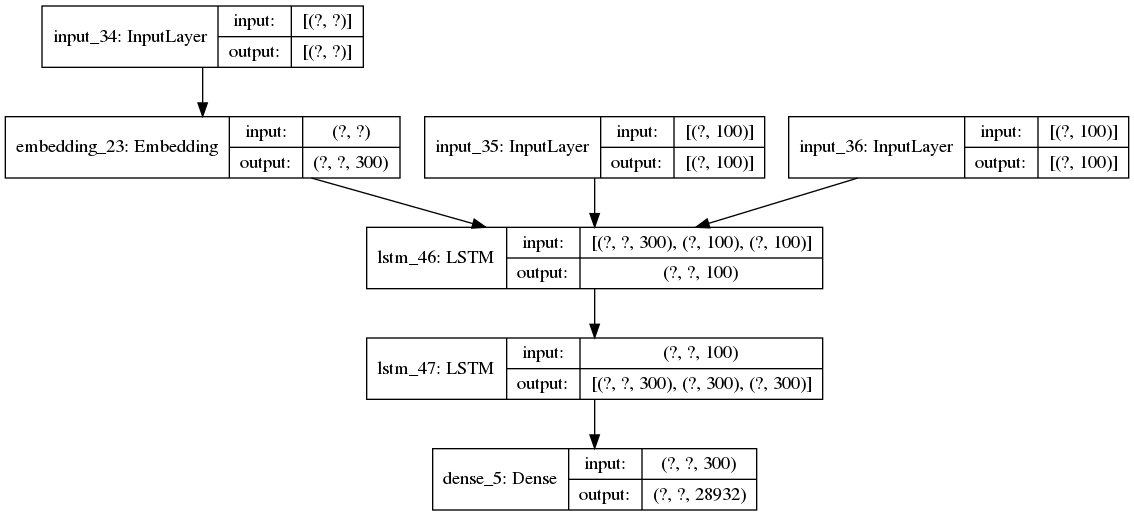

In [133]:
plot_model(decoder_model, show_shapes=True)

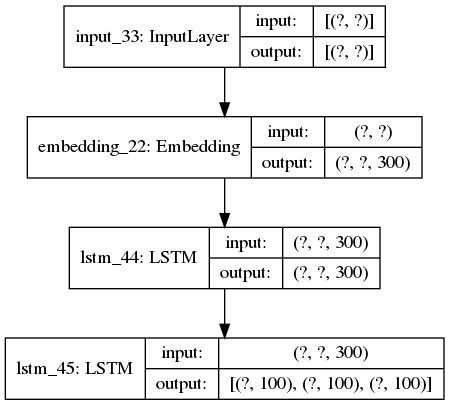

In [132]:
plot_model(encoder_model, show_shapes=True)

In [129]:
train_y[indx:indx+1]

array([[28930,  9309, 15698, 11008, 14719, 24476,  8309, 25896,  3457,
        24318, 28931,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)

In [274]:
train_ori_dst[indx:indx+1]

['The unit is named after Heinrich Rudolf Hertz .\n']

In [91]:
train_x[19:20]

array([[12214, 19938,  9052, 12214,  8560, 17237, 17051, 16711, 24271,
        26058,  9052, 12214, 12619, 19938,  9052, 12214,  4127,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)

In [67]:
from simplifier import *

In [68]:
tokenizer_dst_rev = build_reverse_dict(tokenizer_dst)

In [116]:
indx=23
decode_sequence(train_x[indx:indx+1], encoder_model, decoder_model, tokenizer_dst, tokenizer_dst_rev )

' lrb lrb bushrangers orestes lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb lrb'

In [312]:
train_ori_dst[indx:indx+1]

['He was elected on May 17 , 2005 , defeating the mayor in office , James Hahn .\n']

In [313]:
train_ori_src[indx:indx+1]

['He was elected on May 17 , 2005 , defeating incumbent mayor James Hahn , and then re-elected for a second term in 2009 .\n']

In [75]:
# with open('trainHistory_320_200-250ep', 'rb') as file:
#     history3 = pickle.load(file)
# history2['loss'] += history3['loss']
# history2['val_loss'] += history3['val_loss']
len(history2['loss'])

150

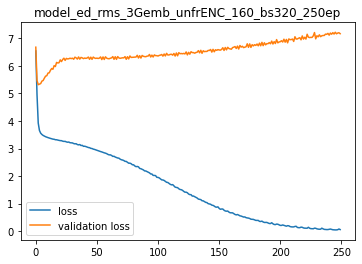

In [286]:
import matplotlib.pyplot as plt
#fig = plt.figure()
plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.title(model_name)
plt.legend()
plt.savefig('training_{}.png'.format(model_name), bbox_inches='tight')
plt.show()
plt.close()

# plt.plot(history2["loss"], label="loss")
# plt.plot(history2["val_loss"], label="validation loss")
# plt.title('Training on 320 samples without GloVe embedding on enc and dec, tr epochs: 100-250')
# plt.legend()
# plt.savefig('training_comparison2.png', bbox_inches='tight')
# plt.show()
# plt.close()

# fig = plt.gcf()
# plt.show()
# plt.draw()
# fig.savefig('training_comparison.png')

In [167]:
from model import *
indx = 21
# hyp = decode_sequence(train_x[indx:indx+1], enc, dec, token_dict)
# ref = tokenize(clean(train_ori_dst[indx:indx+1]))
hyp = tokenize("oil is good")
ref = ["oil is good many"]

bleu_score(ref, hyp)

0.0

In [177]:
ssent = "About 95 species are currently accepted ."
csent = "About 95 species are known ."
rsent = "About 95 species are currently known ."

from SARI import *
SARIsent(ssent, csent, [rsent])

0.6027417027417027

In [178]:
easse

[autoreload of nltk.internals failed: Traceback (most recent call last):
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/py

NameError: name 'easse' is not defined

In [179]:
indx = 19
bleu_score(decode_sequence(train_x[indx:indx+1], enc, dec, token_dict), \
           tokenize(clean(train_ori_dst[indx:indx+1])))

AttributeError: module 'nltk.translate' has no attribute 'bleu_score'

In [57]:
max_bs = 0
for indx in range(0,3200):
    
    #hyp = [get_word(x, tokenizer_dst) for x in np.argmax(model.predict([train_x[indx:indx+1], train_y[indx:indx+1,:]]), axis=2)[0]]
    hyp = tokenize(decode_sequence(train_x[indx:indx+1], enc, dec, token_dict))
    #tokenize?
    # pass
    ref = tokenize(train_ori_dst[indx:indx+1][0])
    #hyp = hyp[0:15]
    #print(hyp)

    #print(ref)

    # print(ref)
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([ref], hyp)
    #print(BLEUscore)
    if BLEUscore>max_bs:
        argmax_bs = indx

NameError: name 'enc' is not defined

In [139]:
1.0377133938315695e-231 -1

-1.0

In [70]:
token_dict_reverse[train_y[0][0]]

'<START>'

In [ ]:
sampled_token_index

In [ ]:
np.argmax(output_tokens)

In [124]:
import gc
gc.collect()

11323

In [ ]:
from model import *

In [ ]:
encoder_model.predict(train_x[12]).shape

In [ ]:
decode_sequence(train_x[12:13], encoder_model, decoder_model, tokenizer_dst)

In [ ]:
import simplifier
batch_size = 32
n_samples = 64
encoder_input_data, decoder_input_data, decoder_target_data = next(generator_ed(train_x, train_y, batch_size, vocabulary_size_source, vocabulary_size_dst, samples=n_samples, shf=False, onehot_dst=True, onehot_src=True))

In [ ]:
encoder_input_data.shape

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=4,
          epochs=20,
          validation_split=0.2)

In [ ]:
import simplifier

In [ ]:
mod.summary()

In [ ]:

# import datetime
# import neptune
# #from simplifier import generator
# #import tensorboard

# #PARAMS = {'n_iterations': 117,
# #          'n_images': 5}

# # neptune.init('l-theorist/sandbox',
# #              api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNDYyODYzNzAtNWMzOC00ZTY5LWJkMjYtYTRhNTVkNWM4MWZjIn0=')





# rms = optimizers.RMSprop(lr=0.001)
# nadm =optimizers.Nadam(learning_rate=0.008, beta_1=0.99, beta_2=0.99999)
# admx = optimizers.Adamax(learning_rate=0.0006, beta_1=0.999, beta_2=0.999999)
# mod.compile(
#     optimizer=rms,
#     #optimizer="adam",
#     #loss="categorical_crossentropy",
#     loss="sparse_categorical_crossentropy",
#     #metrics=["accuracy"]

# )


# with neptune.create_experiment(name='baseline simplifier',
#                                #params=PARAMS
#                               ):
#     neptune_monitor = NeptuneMonitor()
   

batch_size = 64
n_samples = 64 #train_x.shape[0]
history = mod.fit_generator(
    generator(train_x, train_y, batch_size, samples=n_samples, shf=False, onehot=False),
    #data_gen,
    #(train_gen(train_x, 500), one_hot_encode_output(train_y_gen)),
    epochs=100,
    #batch_size=50,
    #validation_split=0.2,
    #steps_per_epoch = train_x.shape[0]/batch_size,
    steps_per_epoch = n_samples/batch_size,
  #  callbacks=[neptune_monitor]
    

)

In [ ]:
mod.predict_classes(train_x[10:12])

In [ ]:
mod.layers

In [ ]:
from tensorflow import keras
from kerastuner import HyperModel


class SimpleHyperModel(HyperModel):
    def __init__(self, vocab_in, vocab_out, length_in, length_out, n_units, \
                    use_emb=None, unfreeze_emb=True):
        self.vocab_in = vocab_in
        self.vocab_out = vocab_out
        self.length_in = length_in
        self.length_out = length_out
        self.n_units = n_units
        self.use_emb = use_emb
        self.unfreeze_emb = unfreeze_emb
        

    def build(self, hp):
        
        if self.use_emb is not None:
            assert self.n_units==self.use_emb.shape[-1], "Embedding dimension should match n_units."
        encoder_input = Input(shape=(self.length_in,))
        encoder_output = layers.Embedding(self.vocab_in+1,
                                        self.n_units,
                                        input_length=self.length_in,
                                        embeddings_initializer='lecun_uniform',
                                        mask_zero=True,
                                        trainable=True)(encoder_input)
        encoder_output = layers.LSTM(self.n_units)(encoder_output)
        encoder_output = layers.RepeatVector(self.length_out)(encoder_output)
        decoder_output = layers.LSTM(self.n_units, return_sequences=True)(encoder_output)
        decoder_output = layers.TimeDistributed(layers.Dense(self.vocab_out+1, activation='softmax'))(decoder_output)

        model = models.Model(encoder_input, decoder_output)
        if self.use_emb is not None:
            model.layers[1].set_weights([self.use_emb])
            model.layers[1].trainable = self.unfreeze_emb




        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            #metrics=['accuracy']
        )
        return model

hypermodel = SimpleHyperModel(vocabulary_size_source, vocabulary_size_dst, sentence_length, \
                  sentence_length_dst, 512)

In [ ]:
from kerastuner.tuners import RandomSearch #,Hyperband
HYPERBAND_MAX_EPOCHS=20
SEED=17
MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 2



tuner = RandomSearch(
    hypermodel,
    #max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='loss',
    max_trials=MAX_TRIALS,
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='randomsearch',
    project_name='fil'
)

In [ ]:
tuner.search_space_summary()

In [ ]:
N_EPOCH_SEARCH = 20
batch_size = 128
n_samples = 256 #train_x.shape[0]
tuner.search_generator(generator(train_x, train_y, batch_size, samples=n_samples, shf=False, onehot=False), epochs=N_EPOCH_SEARCH)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.history.history["loss"], label="loss")
#plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()
plt.close()

In [ ]:
model.summary()

In [ ]:
model.predict(train_x[10:11]).shape

In [ ]:
train_ori_src[10:11]

In [ ]:
train_x[10:11]

In [ ]:
model.predict_classes(train_x[10:11])

In [ ]:
convert(model.predict_classes(train_x[10:11]), token_dict=tokenizer_dst)

In [ ]:
convert(train_x[10:11], tokenizer_src)

In [ ]:
train_ori_dst[10:11]

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("model_all_1.h5")

In [ ]:
np.sum(model.get_weights()[0])

In [ ]:
from tensorflow.keras.models import load_model
mdl = load_model("first_3K_smod.h5")

In [ ]:
np.sum(mdl.get_weights()[0])

In [ ]:
train_x[indx]

In [ ]:
train_y[indx]

In [ ]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)
    integers = [np.argmax(vector) for vector in prediction]
    return convert(integers, tokenizer)

In [ ]:
predict_sequence(model, tokenizer_dst, train_x[10:11])

In [ ]:
prediction = model.predict(train_x[indx], verbose=0)[0]

In [ ]:
integers = [np.argmax(vector) for vector in prediction]

In [ ]:
prediction[1]